In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as scio
import matplotlib
from sklearn.linear_model import LinearRegression
import os
import scienceplots
import glob
import scipy as sc
path_fig = '/home/nbourg/Bureau/clean_plots_treatment_bb/process_scripts/Results_Traj_Detection/Plots/'

path_fig2 = '/home/nbourg/Bureau/clean_plots_treatment_bb/process_scripts/Results_Traj_Detection/Plots/plots_final/'
path_results = '/home/nbourg/Bureau/clean_plots_treatment_bb/process_scripts/Results_Traj_Detection/Calib/'

In [2]:
def get_fps(ws, model, run):
    
    """
    Function that returns the frames per second (fps) at which the images were recorded during the run 'run',
    at the wind speed 'ws', for the 3D-model 'model'.
    
    The function checks the date of the image files to determine the fps rate. Images captured before
    19th June 2023 were recorded at 1 frame per second, while those captured on or after this date
    are recorded at 2 frames per second.
    
    Parameters:
    ws (int): Wind speed identifier.
    model (str): Model identifier.
    run (int): Run identifier.
    
    Returns:
    fps (int): Frames per second (fps) for image capture (1 or 2).
    """
    
    # Construct the path to the image directory
    path = '/home/nbourg/Manip_BB_clean/Manip/wind_' + str(ws) + 'ms/Run' + str(run) + '/' + model + '/'
    
    fps = np.nan  # Initialize fps as NaN
    
    # Check if the directory exists
    if os.path.exists(path):
        
        # Count the number of image files in the directory
        len_files = len(os.listdir(path))

        if len_files > 2:
            
            # Sort the image files by name and get the path of the first image
            path_im = np.sort(glob.glob(path + '*.jpg'))[0]
            
            # Extract the day from the image path (e.g., 19/06/2023)
            day = path_im[-18:-16]
            
            if int(day) < 19:
                # Images captured before 19th June 2023 were recorded at 1 fps
                fps = 1
            else:
                # Images captured on or after 19th June 2023 are recorded at 2 fps
                fps = 2
                
    return fps


In [3]:
def open_model(wind,model,nruns=5,path=path_results):
    
    """
    This function accounts for variations in the launching position 
    of our model in different experiments. In some cases, the initial
    positions (x0, y0) may not always be identical. To ensure consistent
    analysis, this function removes the initial position (x0, y0) for each
    run, aligning the trajectories so that they all originate from the 
    point (0,0) for further analysis.
    
    Parameters:
    wind (int): Wind speed identifier.
    model (str): Model identifier.
    nruns (int): Number of runs (optional, default is 5).
    path (str): Path to results directory (optional).

    Returns:
    x (list of arrays): List of x-coordinates for each run.
    y (list of arrays): List of y-coordinates for each run.
    x_norm (list of arrays): List of normalized x-coordinates for each run.
    y_norm (list of arrays): List of normalized y-coordinates for each run.

    """
    
    
    # Initialize lists to store trajectory data
    x = []
    y = []
    
    x_norm = []
    y_norm = [] 

    # Construct the filename for trajectory data based on wind speed and model
    fn_traj = path + 'WS' + str(wind) + 'Model' + str(model) + '_Calib.mat'
    
    # Load the trajectory data
    f_traj = scio.loadmat(fn_traj)
    xc = f_traj['x_calib'][0]
    yc = f_traj['y_calib'][0]
    
    # Iterate through the runs to process trajectory data
    for i in range(len(xc)):
        
        x_run = xc[i]
        y_run = yc[i]
        
        if len(x_run) != 0:
            # Remove NaN values and invert x-coordinates to align trajectories to (0,0)
            condi = np.logical_and(~np.isnan(x_run), ~np.isnan(y_run))
            x_run = x_run[condi]
            y_run = y_run[condi]
            x_run = -x_run

            # Normalize coordinates relative to the initial point
            x_run_norm = x_run - x_run[0]
            y_run_norm = y_run - y_run[0]

            # Append data to respective lists
            x.append(x_run)
            y.append(y_run)
            x_norm.append(x_run_norm)
            y_norm.append(y_run_norm)

    return x, y, x_norm, y_norm



In [4]:
def get_angle(x,y,fps,path_fig=path_fig,name='o',plot=True):

    """
    Calculate the angle and speed of 3D model trajectories using their (x, y) positions. Trajectory angles
    are determined through the best linear regression fit slope analysis.

    Parameters:
    x (array): Array of x-coordinates.
    y (array): Array of y-coordinates.
    fps (float): Frames per second (fps) for image capture.
    path_fig (str): Path for saving figures (optional).
    name (str): Name for saved figures (optional).
    plot (bool): Set to True to generate a scatter plot (optional).

    Returns:
    angle (float): Calculated angle in degrees.
    speed (float): Calculated speed in m/s.
    pente (float): Slope of the linear regression fit.
    r2 (float): Coefficient of determination (R-squared) of the linear fit.
    
    """
    
    if len(x) == 0:
        # If there are no data points in the input arrays (x, y), 
        # set angle, speed, and pente (slope) to NaN.
        angle = np.nan
        speed = np.nan
        pente = np.nan
        
    else:
        if plot:
            # If the 'plot' flag is set to True, create a scatter plot to visualize the data.
            fig, ax = plt.subplots()
            ax.scatter(x, y)
            ax.set_xlim(-100, 100)
            ax.set_ylim(0, 500)

        # Remove NaN values from the input arrays (x, y) and reshape them for linear regression.
        x_reshaped = x[~np.isnan(x)]
        y_reshaped = y[~np.isnan(y)]
        x_reshaped = x_reshaped.reshape(-1, 1)
        y_reshaped = y_reshaped.reshape(-1, 1)

        # Perform linear regression to find the best fit line.
        reg = LinearRegression().fit(x_reshaped, y_reshaped)
        r2 = reg.score(x_reshaped, y_reshaped)
        pente = reg.coef_[0][0]

        # Calculate the change in x and y coordinates (dx, dy).
        dx = x[-1] - x[0]
        dy = y[-1] - y[0]

        if r2 > 0.8:
            # If the R-squared value of the linear fit is greater than 0.8, 
            # adjust dy based on the slope (pente).
            dy = dx * pente
            if plot:
                # Plot the linear regression line in red.
                ax.plot(x, pente * x + reg.intercept_, c='r', linewidth=2)
        else:
            if plot:
                # Plot a straight line connecting the first and last points in black.
                ax.plot([x[0], x[-1]], [y[0], y[-1]], c='k', linewidth=2)

        # Calculate the angle based on the change in x and y coordinates.
        angle = np.arctan(dx / dy) * 180 / np.pi

        # Calculate the distance (dist) and speed (in m/s) based on dx, dy, and fps.
        dist = np.sqrt((dx / 100) ** 2 + (dy / 100) ** 2)
        dt = len(x) / fps
        speed = dist / dt

        if plot:
            # If 'plot' is True, save the figure and close the plot.
            fig.savefig(path_fig + 'verif_pente/' + name + '.png', facecolor='w')
            plt.close()

    # Return the calculated angle, speed, pente (slope), and R-squared (r2).
    return angle, speed, pente, r2


Computing the wind speed at 10m height from wind speed at 0.7m height, using $z_0$ measured by 

Elpida Vonta, Denis Bourras, Julien Touboul, Christopher Luneau, Philippe Fraunié, Alexei
Sentchev, Antoine Villefer, and Saïd Benjeddou. Imbalance term in the tke budget over waves:
preliminary comparisons between open sea and wind-wave tunnel measurements, 2022

In [5]:
# U10 equivalents from Elpida Vonta's report
z0 = 1e-3 * np.array([0.066 - 0.3 * (0.129 - 0.066),
                     0.066,
                     0.272,
                     0.383,
                     np.mean([0.383, 0.483]),
                     0.483,
                     0.721,
                     0.721 + (0.721 - 0.483)])

ws = np.array([1, 2, 4, 6, 7, 8, 10, 12])
U10 = ws * np.log(10 / z0) / np.log(0.7 / z0)
U0 = ws * np.log(0.2 / z0) / np.log(0.7 / z0)
print(U10)

[ 1.27681702  2.57378534  5.35451352  8.12434879  9.51956871 10.92273793
 13.86621703 16.84019246]


In [6]:
np.nanmean(U10/ws)

1.3464559881863019

In [7]:
np.nanmean(U0/ws)

0.8367864645858853

# FIG 1

Trajectories of the Right-Handed Default model (Left panel) and the Left-Handed Default model (Right panel) within the wind tunnel. The models were launched from the (0,0) position and tracked over a 20-second duration. The color-coding of the trajectories corresponds to the wind speed conditions during the experiment, initially measured at a height of 0.7 meters and then scaled to 10 meters, denoted as $U_{10}$. Additionally, a grey shading in the background displays angle dials, with each shade of grey representing 10-degree increments.

/tmp/ipykernel_8169/421771557.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels([-1, 0, 1])
/tmp/ipykernel_8169/421771557.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels([0, 1, 2, 3, 4, 5])


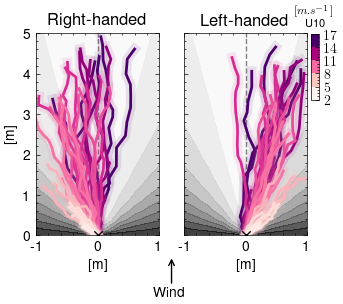

In [14]:
import matplotlib as mpl
# Set plot line width and color map
lw = 2
cmaplines  = 'RdPu'
model = '11111'
cmaprdpu = cmap= plt.get_cmap(cmaplines)
plt.style.use(['science', 'high-contrast'])
plt.rc('font', family='Helvetica')

# Define frame per second (fps) values
fps = [2, 1, 1, 2, 2, 1, 1, 2]

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True)

# Configure subplot settings
for ax in axs:
    ax.set_xlim(-100, 100)
    ax.set_ylim(0, 500)
    ax.axvline(0, c='grey', linestyle='--')
    a = np.linspace(-600, 600)
    b = np.linspace(-600, 600)
    
    # Grey shading in the background displays angle dials, with each shade
    # of grey representing 10-degree increments.
    [c, d] = np.meshgrid(a, b)
    ang_cf = np.abs(np.arctan2(c, d) * 180 / np.pi)
    cf = ax.contourf(c, d, ang_cf, alpha=0.8, levels=18, cmap='Greys', vmin=0, vmax=90)

# Iterate through wind speeds
for ws, step, u in zip([1, 2, 4, 6, 7, 8, 10, 12][::-1], fps[::-1], U10[::-1]):
    col = cmaprdpu(u / 17)

    for hand, nu in zip(['L', 'R'], [1, 0]):
        # Check if calibration data file exists
        if os.path.exists(path_results + 'WS' + str(ws) + 'Model' + hand + model + '_Calib.mat'):
            _, _, xr, yr = open_model(ws, hand + model, path=path_results)
            
            # Iterate through trajectories
            for n in range(len(xr)):
                xtp = xr[n][::step]
                ytp = yr[n][::step]
                l = 20
                
                # Plot trajectories
                axs[nu].plot(xtp[:l], ytp[:l], color=col, linewidth=7, alpha=0.1)
                axs[nu].plot(xtp[:l], ytp[:l], color=col, linewidth=2, alpha=1)

    axs[1].set_title('Left-handed', fontsize=12)
    axs[0].set_title('Right-handed', fontsize=12)

# Set color map boundaries and normalize
bounds = [2, 5, 8, 11, 14, 17]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmaplines, norm=norm)

# Set axis labels and tick labels
axs[0].set_ylabel('[m]')
axs[0].set_xlabel('[m]')
axs[1].set_xlabel('[m]')

legend=False
for a in fig.get_axes():
    a.set_xticklabels([-1, 0, 1])
    a.set_yticklabels([0, 1, 2, 3, 4, 5])
    if legend:
        a.scatter(0,0,marker='x',c='k',zorder=10,label='Launching position')
        legend=True
    else:
        a.scatter(0,0,marker='x',c='k',zorder=10)

# Add color bar
cax = fig.add_axes([0.91, 0.627, 0.025, 0.25])
cb = fig.colorbar(sm, cax=cax, orientation='vertical')
cb.ax.set_title('$[m.s^{-1}]$\nU10', fontsize=8)
axs[0].annotate('', xy=(1.1, -0.1), xycoords='axes fraction', xytext=(1.1, -0.25), 
                 arrowprops=dict(arrowstyle="->", color='k'))
axs[0].text(.95,-.3,'Wind',transform=axs[0].transAxes)
fig.savefig(path_fig2 + 'FIG_LinesScienceU10_helvetica.png', dpi=500, facecolor='w')




plt.show()

In [35]:
path_fig

'/home/nbourg/Bureau/clean_plots_treatment_bb/process_scripts/Results_Traj_Detection/Plots/'

# FIG 2
Evolution of Default models drifting angles with respect to wind speed (originally measured at a height of 0.7m and scaled to 10 meters, denoted as $U_{10}$). The black circles represent the average drifting angles obtained by averaging results from both left and right-handed models across five runs. Error bars indicate the range of measured angles at each wind speed. An exponential curve (shown as a grey dashed line) has been fitted to the data points, with its equation displayed on the plot. The grey shading represents the uncertainty associated with the parameters of the exponential fit.

R^2: speed 0.9434104408297457


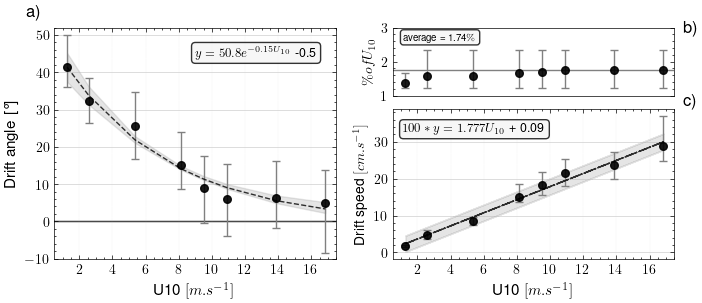

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy as sc
from matplotlib.gridspec import GridSpec


def monoExp(x, m, t, b):
    return m*np.exp(-t*x)+b

def linear(x,a,b):
    return a*x+b

# Define wind speeds and runs
speed = [1, 2, 4, 6, 7, 8, 10, 12]
runs = [1, 2, 3, 4, 5]
ms = 80

# Set the plotting style
plt.style.use(["science", "high-contrast"])
plt.rc('font', family='Helvetica')

# Create a figure and axis
fig = plt.figure(figsize=(8, 3))
gs = GridSpec(3, 2, figure=fig)


ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[1:, 1])

inset_ax = fig.add_subplot(gs[0, 1])
inset_ax.set_ylabel('$\% of U_{10}$')
inset_ax.set_ylim(1,3)

ax0.set_ylim(-10, 52)
ax0.plot(np.linspace(0.5, 18.5), 0 * np.ones(np.linspace(0.5, 18.5).shape), c='k', zorder=0)

for a in [ax0,ax1]:
    a.set_xticks([2, 4, 6, 8, 10, 12, 14, 16])
    a.set_xlim(0.5, 17.5)
    a.yaxis.grid(zorder=0, alpha=0.6)

s = []
a = []

s2 = []
a2 = []

b,b2 = [], []
perc = []
for (ws, u) in zip([1, 2, 4, 6, 7, 8, 10, 12], U10):
    
    # open data 
    _, _, xr, yr = open_model(ws, 'R11111', path=path_results)
    _, _, xl, yl = open_model(ws, 'L11111', path=path_results)

    run_right = []
    run_left = []
    
    run_right_speed = []
    run_left_speed = []
    
    # Retrieve angles
    for run in range(5):
        
        fps_r = get_fps(ws, 'R11111', run)
        fps_l = get_fps(ws, 'L11111', run)

        angle_r, speed_r, _, _ = get_angle(xr[run], yr[run], fps_r)
        angle_l, speed_l, _, _ = get_angle(xl[run], yl[run], fps_l)
        run_right.append(-angle_r)
        run_left.append(angle_l)
        
        run_right_speed.append(100*speed_r)
        run_left_speed.append(100*speed_l)
        
        perc.append(100*speed_r/u)
        perc.append(100*speed_l/u)
        
    s.append(u * np.ones(len(run_right)))
    a.append(run_right)
    b.append(run_right_speed)
    
    s2.append(u * np.ones(len(run_left)))
    a2.append(run_left)
    b2.append(run_left_speed)
    
    ax0.scatter(u, np.nanmean(np.concatenate([run_right, run_left])), color="k", s=30, alpha=0.9, zorder=5)
    ax0.errorbar(u, np.nanmean(np.concatenate([run_right, run_left])),
                yerr = [[np.nanmean(np.concatenate([run_right,run_left]))-np.nanmin(np.concatenate([run_right,run_left]))],
                        [np.nanmax(np.concatenate([run_right,run_left]))-np.nanmean(np.concatenate([run_right,run_left]))]],
                c="gray", linewidth=1, capsize=3)

    
    ax1.scatter(u, np.nanmean(np.concatenate([run_right_speed, run_left_speed])), color="k", s=30, alpha=0.9, zorder=5)
    ax1.errorbar(u, np.nanmean(np.concatenate([run_right_speed, run_left_speed])),
                yerr = [[np.nanmean(np.concatenate([run_right_speed,run_left_speed]))-np.nanmin(np.concatenate([run_right_speed,run_left_speed]))],
                        [np.nanmax(np.concatenate([run_right_speed,run_left_speed]))-np.nanmean(np.concatenate([run_right_speed,run_left_speed]))]],
                c="gray", linewidth=1, capsize=3)

    inset_ax.scatter(u, np.nanmean(perc), color="k", s=30, alpha=0.9, zorder=7)
    inset_ax.errorbar(u, np.nanmean(perc),
                yerr = [[np.nanmean(perc)-np.nanmin(perc)],
                        [np.nanmax(perc)-np.nanmean(perc)]],
                c="gray", linewidth=1, capsize=3,zorder=5)

# Combine lists of s and a
ss1 = np.concatenate(s)
aa1 = np.concatenate(a)
bb1 = np.concatenate(b)

ss2 = np.concatenate(s2)
aa2 = np.concatenate(a2)
bb2 = np.concatenate(b2)

ss = np.concatenate([ss1, ss2])
aa = np.concatenate([aa1, aa2])
bb = np.concatenate([bb1, bb2])

#--------------- FIT SPEED

# Remove NaN values
xx = ss[~np.isnan(bb)]
yy = bb[~np.isnan(bb)]

# Fitting a linear regression model
coefficients = np.polyfit(xx, yy, 1)
slope = coefficients[0]
intercept = coefficients[1]

# Computing uncertainties
yy_pred = np.polyval(coefficients, xx)
residuals = yy - yy_pred
std_residuals = np.std(residuals)
std_slope = std_residuals / np.sqrt(len(xx) * np.var(xx))
std_intercept = std_residuals * np.sqrt(1/len(xx) + np.mean(xx)**2 / (len(xx) * np.var(xx)))

# Plotting the fitted line
ax1.plot(xx, np.polyval(coefficients, xx), c='k', linestyle='-.', alpha=0.8, label='fit')

# Plotting the uncertainties
ax1.fill_between(xx, np.polyval(coefficients, xx) - std_residuals, 
                   np.polyval(coefficients, xx) + std_residuals, color='grey', alpha=0.2)
# Text box with fit equation
props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.8)
ax1.text(1.15,35,'$100*y= '+str(slope)[0:5]+' U_{10}$ + '+str(intercept)[0:4], fontsize=9,
        verticalalignment='top', bbox=props)


# Calculate TSS
TSS = np.sum((yy - np.mean(yy))**2)

# Calculate RSS
RSS = np.sum((yy - yy_pred)**2)

# Calculate R^2
r_squared = 1 - (RSS / TSS)

print("R^2: speed", r_squared)


#------------------------------------- FIT ANGLE


# Remove NaN values
xx = ss[~np.isnan(aa)]
yy = aa[~np.isnan(aa)]

# Initial parameters for the curve fit
p0 = (2000, 0.1, 50)

# Perform the curve fit
params, cv = sc.optimize.curve_fit(monoExp, xx, yy, p0)
m, t, b = params

perr = np.sqrt(np.diag(cv))

# Sort the data for plotting
idx = np.argsort(xx)

# Plot the fitted curve
ax0.plot(xx[idx], monoExp(xx, m, t, b)[idx], c='k', linestyle='--', alpha=0.8, label='fit')

# Fill between the fitted curve
ax0.fill_between(xx[idx], monoExp(xx, m - perr[0], t - perr[1], b - perr[2])[idx],
                monoExp(xx, m + perr[0], t + perr[1], b + perr[2])[idx], color='grey', alpha=0.2)

#--------------------------------------

# Text box with fit equation
props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.8)
ax0.text(9,47,'$y= '+str(m)[0:4]+'e^{-'+str(t)[0:4]+'U_{10}}$ '+str(b)[0:4], fontsize=9,
        verticalalignment='top', bbox=props)

# Set y-ticks and labels
ax0.set_yticks([-10, 0, 10, 20, 30, 40, 50], fontsize=11)

# Set axis labels
ax0.set_ylabel('Drift angle [°]', fontsize=11)
for a in [ax0,ax1]:
    a.set_xlabel('U10 $[m.s^{-1}]$', fontsize=11)
    a.xaxis.grid(linestyle='--', alpha=0.6, linewidth=0.1)

ax1.set_ylabel('Drift speed $[cm.s^{-1}]$')    

inset_ax.set_xlim(ax0.get_xlim())
inset_ax.set_xticks([])
inset_ax.axhline(np.nanmean(perc),c='grey',zorder=0)
inset_ax.text(1.15,2.85,'average = 1.74$\%$', fontsize=7,
        verticalalignment='top', bbox=props)

ax0.text(-.1, 1.1, 'a)', transform=ax0.transAxes, fontsize=12, fontweight='bold', va='top')
ax1.text(1.031, 1.1, 'c)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top')
inset_ax.text(1.031, 1.1, 'b)', transform=inset_ax.transAxes, fontsize=12, fontweight='bold', va='top')


fig.savefig(path_fig2 + 'FIG_DefaultAngleU10_helvetica.png', dpi=500, facecolor='w')
plt.show()

In [16]:
np.nanmean(perc)

1.7412587656033558

In [17]:
residuals = yy- monoExp(xx, *params)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((yy-np.mean(yy))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

0.836951527290031


# Drifting speed

In [18]:
# Define wind speeds and runs
speed = [1, 2, 4, 6, 7, 8, 10, 12]
runs = [1, 2, 3, 4, 5]
ms = 80

percentage_ws = []
percentage_u10 = []
angle2 = []
angle8 = []
for (ws, u) in zip([1, 2, 4, 6, 7, 8, 10, 12], U10):
    
    # open data 
    _, _, xr, yr = open_model(ws, 'R11111', path=path_results)
    _, _, xl, yl = open_model(ws, 'L11111', path=path_results)

    
    # Retrieve angles
    for run in range(5):
        
        fps_r = get_fps(ws, 'R11111', run)
        fps_l = get_fps(ws, 'L11111', run)

        angle_r, speed_r, _, _ = get_angle(xr[run], yr[run], fps_r)
        angle_l, speed_l, _, _ = get_angle(xl[run], yl[run], fps_l)
        
        percentage_ws.append(speed_r/ws)
        percentage_ws.append(speed_l/ws)

        percentage_u10.append(speed_r/u)
        percentage_u10.append(speed_l/u)


        if ws==2:
            angle2.append(angle_r)
            angle2.append(-angle_l)
        
        elif ws==8:
            angle8.append(angle_r)
            angle8.append(-angle_l)    
        
print('MEDIAN')
print(np.nanmedian(percentage_u10)*100)
print(np.nanstd(percentage_u10)*100)

print('2m/s : ',np.nanmedian(angle2),' +/- ', np.nanstd(angle2))
print('8m/s : ',np.nanmedian(angle8),' +/- ', np.nanstd(angle8))

print('MEAN')
print(np.nanmean(percentage_u10)*100)
print(np.nanstd(percentage_u10)*100)

print('2m/s : ',np.nanmean(angle2),' +/- ', np.nanstd(angle2))
print('8m/s : ',np.nanmean(angle8),' +/- ', np.nanstd(angle8))


MEDIAN
1.7342567968136218
0.26266355422275706
2m/s :  -33.32985131413575  +/-  4.0111133344391225
8m/s :  -7.087618596016901  +/-  5.319690492462288
MEAN
1.7412587656033558
0.26266355422275706
2m/s :  -32.32234701766756  +/-  4.0111133344391225
8m/s :  -6.001406586172742  +/-  5.319690492462288


# Drifting speed small

In [19]:
# Define wind speeds and runs
speed = [2,8]
runs = [1, 2, 3, 4, 5]
ms = 80

percentage_ws = []
percentage_u10 = []

angle2 = []
angle8 = []
for (ws, u) in zip([2,8], [U10[1], U10[5]]):
    
    # open data 
    _, _, xr, yr = open_model(ws, 'R21111', path=path_results)
    _, _, xl, yl = open_model(ws, 'L21111', path=path_results)

    if ws == 2:
        nruns=5
    else:
        nruns=3
    
    # Retrieve angles
    for run in range(nruns):
        fps_r = get_fps(ws, 'R21111', run)
        fps_l = get_fps(ws, 'L21111', run)

        angle_r, speed_r, _, _ = get_angle(xr[run], yr[run], fps_r)
        angle_l, speed_l, _, _ = get_angle(xl[run], yl[run], fps_l)
        
        percentage_ws.append(speed_r/ws)
        percentage_ws.append(speed_l/ws)

        percentage_u10.append(speed_r/u)
        percentage_u10.append(speed_l/u)
        

        if ws==2:
            angle2.append(angle_r)
            angle2.append(-angle_l)
        
        elif ws==8:
            angle8.append(angle_r)
            angle8.append(-angle_l)    
        
print('MEDIAN')
print(np.nanmedian(percentage_u10)*100)
print(np.nanstd(percentage_u10)*100)

print('2m/s : ',np.nanmedian(angle2),' +/- ', np.nanstd(angle2))
print('8m/s : ',np.nanmedian(angle8),' +/- ', np.nanstd(angle8))

print('MEAN')
print(np.nanmean(percentage_u10)*100)
print(np.nanstd(percentage_u10)*100)

print('2m/s : ',np.nanmean(angle2),' +/- ', np.nanstd(angle2))
print('8m/s : ',np.nanmean(angle8),' +/- ', np.nanstd(angle8))


MEDIAN
1.5480913973786967
0.6011444328775474
2m/s :  -42.36512807883436  +/-  10.804488402841477
8m/s :  -0.336547386780056  +/-  2.432252459842251
MEAN
1.610219504153965
0.6011444328775474
2m/s :  -40.91732175589866  +/-  10.804488402841477
8m/s :  -1.5162035375927854  +/-  2.432252459842251


# Drifting speed white drifter

In [20]:


path_results_drifter = '/home/nbourg/Bureau/clean_plots_treatment_bb/Results/'
model = "WhiteDrifter"
speed = [1,2,4,6,7,8,10,12]

percentage_u10 = []
percentage_ws = []

angle2 = []
angle8 = []

for (ws,u) in zip(speed,U10):
    filename = 'Drifter_results_WS'+str(ws)+ '_Model_'+model+'.mat'
    file_res = scio.loadmat(path_results_drifter+filename)
    
    drift_speed = file_res['drift_speed'][0][0]*100
    drift_angle = file_res['drift_angle'][0][0]


    percentage_ws.append(drift_speed/ws)

    percentage_u10.append(drift_speed/u)

    if ws==2:
        angle2.append(drift_angle)

    elif ws==8:
        angle8.append(drift_angle)
        
        
print('MEDIAN')
print(np.nanmedian(percentage_u10))
print(np.nanstd(percentage_u10))

print('2m/s : ',np.nanmedian(angle2),' +/- ', np.nanstd(angle2))
print('8m/s : ',np.nanmedian(angle8),' +/- ', np.nanstd(angle8))

print('MEAN')
print(np.nanmean(percentage_u10))
print(np.nanstd(percentage_u10))

print('2m/s : ',np.nanmean(angle2),' +/- ', np.nanstd(angle2))
print('8m/s : ',np.nanmean(angle8),' +/- ', np.nanstd(angle8))


MEDIAN
1.8726873993797724
0.7574599176557879
2m/s :  2.66787307642791  +/-  0.0
8m/s :  -0.6504397087305558  +/-  0.0
MEAN
2.1637196569701556
0.7574599176557879
2m/s :  2.66787307642791  +/-  0.0
8m/s :  -0.6504397087305558  +/-  0.0


# trying  Leeway stuff


In [21]:
def get_speed_leeway(x,y,fps,path_fig=path_fig,name='o',plot=False):

    """
    Calculate the angle and speed of 3D model trajectories using their (x, y) positions. Trajectory angles
    are determined through the best linear regression fit slope analysis.

    Parameters:
    x (array): Array of x-coordinates.
    y (array): Array of y-coordinates.
    fps (float): Frames per second (fps) for image capture.
    path_fig (str): Path for saving figures (optional).
    name (str): Name for saved figures (optional).
    plot (bool): Set to True to generate a scatter plot (optional).

    Returns:
    angle (float): Calculated angle in degrees.
    speed (float): Calculated speed in m/s.
    pente (float): Slope of the linear regression fit.
    r2 (float): Coefficient of determination (R-squared) of the linear fit.
    
    """
    
    if len(x) == 0:
        # If there are no data points in the input arrays (x, y), 
        # set angle, speed, and pente (slope) to NaN.
        angle = np.nan
        speed = np.nan
        pente = np.nan
        
    else:
        if plot:
            # If the 'plot' flag is set to True, create a scatter plot to visualize the data.
            fig, ax = plt.subplots()
            ax.scatter(x, y)
            ax.set_xlim(-100, 100)
            ax.set_ylim(0, 500)

        # Remove NaN values from the input arrays (x, y) and reshape them for linear regression.
        x_reshaped = x[~np.isnan(x)]
        y_reshaped = y[~np.isnan(y)]
        x_reshaped = x_reshaped.reshape(-1, 1)
        y_reshaped = y_reshaped.reshape(-1, 1)

        # Perform linear regression to find the best fit line.
        reg = LinearRegression().fit(x_reshaped, y_reshaped)
        r2 = reg.score(x_reshaped, y_reshaped)
        pente = reg.coef_[0][0]

        # Calculate the change in x and y coordinates (dx, dy).
        dx = x[-1] - x[0]
        dy = y[-1] - y[0]

        if r2 > 0.8:
            # If the R-squared value of the linear fit is greater than 0.8, 
            # adjust dy based on the slope (pente).
            dy = dx * pente
            if plot:
                # Plot the linear regression line in red.
                ax.plot(x, pente * x + reg.intercept_, c='r', linewidth=2)
        else:
            if plot:
                # Plot a straight line connecting the first and last points in black.
                ax.plot([x[0], x[-1]], [y[0], y[-1]], c='k', linewidth=2)
        dt = len(x) / fps

        crosswind = (dx/100)/dt
        downwind = (dy/100)/dt
        dist = np.sqrt((dx / 100) ** 2 + (dy / 100) ** 2)/dt


    # Return the calculated angle, speed, pente (slope), and R-squared (r2).
    return crosswind, downwind,dist

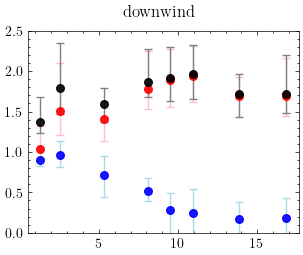

In [22]:

import scipy as sc

def monoExp(x, m, t, b):
    return m*np.exp(-t*x)+b


# Define wind speeds and runs
speed = [1, 2, 4, 6, 7, 8, 10, 12]
runs = [1, 2, 3, 4, 5]
ms = 80

# Set the plotting style
plt.style.use(["science", "high-contrast"])

# Create a figure and axis
fig, ax = plt.subplots()


for (ws, u) in zip([1, 2, 4, 6, 7, 8, 10, 12], U10):
    
    # open data 
    _, _, xr, yr = open_model(ws, 'R11111', path=path_results)
    _, _, xl, yl = open_model(ws, 'L11111', path=path_results)

    run_right = []
    run_left = []
    
    # Retrieve angles
    for run in range(5):
        
        fps_r = get_fps(ws, 'R11111', run)
        fps_l = get_fps(ws, 'L11111', run)

        crosswind_r, downwind_r,_ = get_speed_leeway(xr[run], yr[run], fps_r)
        crosswind_l, downwind_l,_ = get_speed_leeway(xl[run], yl[run], fps_l)
        run_right.append(-100*crosswind_r/u)
        run_left.append(100*crosswind_l/u)

    ax.scatter(u, np.nanmean(np.concatenate([run_right, run_left])), color="blue", s=30, alpha=0.9, zorder=5)
    ax.errorbar(u, np.nanmean(np.concatenate([run_right, run_left])),
                yerr = [[np.nanmean(np.concatenate([run_right,run_left]))-np.nanmin(np.concatenate([run_right,run_left]))],
                        [np.nanmax(np.concatenate([run_right,run_left]))-np.nanmean(np.concatenate([run_right,run_left]))]],
                c="lightblue", linewidth=1, capsize=3)
fig.suptitle('crosswind')
ax.set_ylabel('% of U10')
ax.set_ylim(0,2.5)

#plt.show()    
######--------------------


for (ws, u) in zip([1, 2, 4, 6, 7, 8, 10, 12], U10):
    
    # open data 
    _, _, xr, yr = open_model(ws, 'R11111', path=path_results)
    _, _, xl, yl = open_model(ws, 'L11111', path=path_results)

    run_right = []
    run_left = []
    
    dist_right=[]
    dist_left=[]
    # Retrieve angles
    for run in range(5):
        
        fps_r = get_fps(ws, 'R11111', run)
        fps_l = get_fps(ws, 'L11111', run)

        crosswind_r, downwind_r,dist_r = get_speed_leeway(xr[run], yr[run], fps_r)
        crosswind_l, downwind_l,dist_l = get_speed_leeway(xl[run], yl[run], fps_l)
        run_right.append(100*downwind_r/u)
        run_left.append(100*downwind_l/u)
        
        
        dist_right.append(100*dist_r/u)
        dist_left.append(100*dist_l/u)

    
    ax.scatter(u, np.nanmean(np.concatenate([run_right, run_left])), color="r", s=30, alpha=0.9, zorder=5)
    ax.errorbar(u, np.nanmean(np.concatenate([run_right, run_left])),
                yerr = [[np.nanmean(np.concatenate([run_right,run_left]))-np.nanmin(np.concatenate([run_right,run_left]))],
                        [np.nanmax(np.concatenate([run_right,run_left]))-np.nanmean(np.concatenate([run_right,run_left]))]],
                c="pink", linewidth=1, capsize=3)

    
    ax.scatter(u, np.nanmean(np.concatenate([dist_right, dist_left])), color="k", s=30, alpha=0.9, zorder=5)
    ax.errorbar(u, np.nanmean(np.concatenate([dist_right, dist_left])),
                yerr = [[np.nanmean(np.concatenate([dist_right,dist_left]))-np.nanmin(np.concatenate([dist_right,dist_left]))],
                        [np.nanmax(np.concatenate([dist_right,dist_left]))-np.nanmean(np.concatenate([dist_right,dist_left]))]],
                c="gray", linewidth=1, capsize=3)
fig.suptitle('downwind')
ax.set_ylabel('% of U10')
ax.set_ylim(0,2.5)
plt.show()   
    


# FIG 3
Polar plot exploring the relationships between wind speed (U10) and drifting behavior of various 3D models. The three subplots highlight different models (indicated by markers and colors) and their respective drifting angles and speeds. The drifting angle is represented by the angle in degrees, while the speed is scaled and shown as a percentage of $U_{10}$. The data is shown for three different $U_{10}$ (3, 8, and 17 m/s).

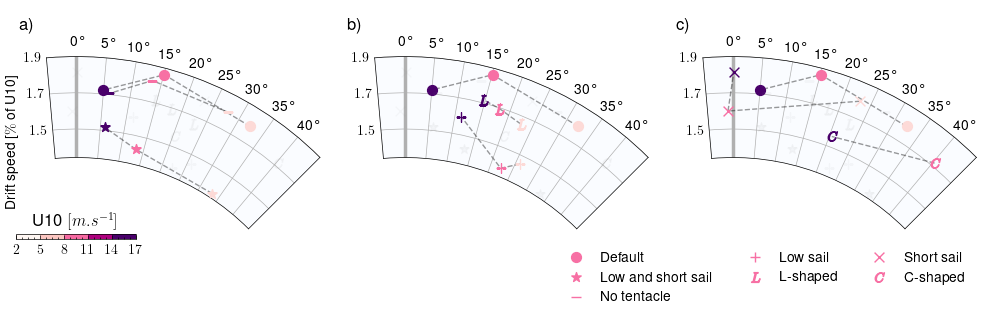

In [24]:
import matplotlib as mpl
cmap = plt.get_cmap('RdPu')
# List of different model identifiers
modelss = [
    '11111',          # Default model
    '11211',          # Model with low sail
    '12111',          # Model with short sail
    '12211',          # Model with low and short sail
    'C1111',          # C-shaped model
    'L1111',          # L-shaped model
    '11111_notent'    # Model without tentacle
]

mpl.style.use(['science', 'high-contrast'])

plt.rc('font', family='Helvetica')

# Human-readable names corresponding to model identifiers
names = [
    'Default',               # Default model name
    'Low sail',              # Model with a low sail name
    'Short sail',            # Model with a short sail name
    'Low and short sail',    # Model with low and short sail name
    'C-shaped',              # C-shaped model name
    'L-shaped',              # L-shaped model name
    'No tentacle'            # Model without a tentacle name
]

# List of markers used for plotting models
markers = [
    'o',    # Circle marker
    '+',    # Plus marker
    'x',    # X marker
    '*',    # Asterisk marker
    '$C$',  # C-shaped marker (using LaTeX style)
    '$L$',  # L-shaped marker (using LaTeX style)
    '_'     # Underscore marker
]

col_bools = [
    [True, False, False, True, False, False, True],
    [True, True, False, False, False, True, False],
    [True, False, True, False, True, False, False]
]

# Create a polar subplot with three columns
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 5),
                      ncols=3, nrows=1, sharex=True, sharey=True)
def_leg = True

# Iterate through subplots
for isp in range(len(col_bools)):
    col_bool = col_bools[isp]
    wind_speeds = [2, 6, 12]
    U10_chosed = [U10[1], U10[3], U10[7]]
    
    import warnings 
    warnings.filterwarnings("ignore")

    # Configure subplot settings
    ax[isp].set_thetamin(-5)
    ax[isp].set_thetamax(45)
    ax[isp].set_theta_zero_location("N")
    ax[isp].set_theta_direction('clockwise')
    ax[isp].set_rmax(3.5)
    ax[isp].set_rorigin(0)
    ax[isp].set_rticks([1.5, 1.7, 1.9])
    
    ax[isp].set_xticks(np.pi/180*np.array([0, 5, 10, 15, 20, 25, 30, 35, 40]))
    ax[isp].xaxis.grid(zorder=0)
    legends = [False] * len(modelss)
    ax[isp].set_facecolor('w')
    ind = 0
    gridlines = ax[isp].xaxis.get_gridlines()
    gridlines[ind].set_linewidth(2.5)

    a = np.full((len(wind_speeds), len(modelss)), np.nan)
    b = np.full((len(wind_speeds), len(modelss)), np.nan)

    # Iterate through wind speeds
    for ws, i, u in zip(wind_speeds, range(len(wind_speeds)), U10_chosed):
        for model, name, mark, leg, j, co in zip(modelss, names, markers, legends, range(len(modelss)), col_bool):
            angle_r1 = []
            speed_r1 = []

            for hand, nu in zip(['L', 'R'], [1, -1]):
                if os.path.exists(path_results+'WS'+str(ws)+'Model'+hand+model+'_Calib.mat'):
                    _, _, xr, yr = open_model(ws, hand+model, path=path_results)

                    for run in range(len(xr)):
                        fps = get_fps(ws, hand+model, run)
                        angle_r, speed_r, _, _ = get_angle(xr[run], yr[run], fps,
                                                       path_fig=path_fig,
                                                       name=str(ws)+hand+model+str(run), plot=False)
                        angle_r1.append(nu * angle_r)
                        speed_r1.append(speed_r)

            angle1 = np.nanmean(angle_r1)
            speed1 = np.nanmean(speed_r1/u)

            a[i][j] = np.deg2rad(angle1)
            b[i][j] = speed1 * 100

            cmaplines = 'RdPu'
            cmaprdpu = plt.get_cmap(cmaplines)
            if co:
                c = cmaprdpu(u / np.nanmax(U10))
                al = 1
            else:
                c = 'grey'
                al = 0.051

            if not np.isnan(angle1):
                if not leg and ws == 6 and c == cmaprdpu(u / np.nanmax(U10)):
                    if model != '11111':
                        ax[isp].scatter(np.deg2rad(angle1), speed1 * 100, facecolor=c,
                                       alpha=al, marker=mark, zorder=5, s=50, label=name)
                        leg = True
                    elif def_leg:
                        ax[isp].scatter(np.deg2rad(angle1), speed1 * 100, facecolor=c,
                                       alpha=al, marker=mark, zorder=5, s=50, label=name)
                        def_leg = False
                    else:
                        ax[isp].scatter(np.deg2rad(angle1), speed1 * 100, facecolor=c,
                                       alpha=al, marker=mark, zorder=5, s=50)
                else:
                    ax[isp].scatter(np.deg2rad(angle1), speed1 * 100, facecolor=c,
                                   alpha=al, marker=mark, zorder=5, s=50)

    for j in range(len(modelss)):
        if col_bool[j]:
            al = 0.4
        else:
            al = 0
        ax[isp].plot(a[:, j], b[:, j], c='k', linewidth=1, linestyle='--', alpha=al)
    ax[isp].set_rticks([1.5, 1.7, 1.9])

    ax[isp].patch.set_color('aliceblue')
    ax[isp].patch.set_alpha(.3)
    ax[0].set_ylabel('Drift speed [$\%$ of U10]')
    if isp == 2:
        fig.legend(ncol=3, bbox_to_anchor=(0.5, 0., 0.4, 0.3))

    bounds=[2,5,8,11,14,17]
    norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
    sm = plt.cm.ScalarMappable(cmap=cmaplines, norm=norm)
    
cax = fig.add_axes([0.1, 0.3, 0.1, 0.01])
cb=fig.colorbar(sm,cax=cax,orientation='horizontal',pad=-2)
cb.ax.set_title('U10 $[m.s^{-1}]$')

ax[0].text(-.1, 0.95, 'a)', transform=ax[0].transAxes, fontsize=12, fontweight='bold', va='top')
ax[1].text(-.1, 0.95, 'b)', transform=ax[1].transAxes, fontsize=12, fontweight='bold', va='top')
ax[2].text(-.1, 0.95, 'c)', transform=ax[2].transAxes, fontsize=12, fontweight='bold', va='top')


fig.savefig(path_fig2+'PolarAllSubplotsMean_helvetica.png',facecolor='w',dpi=500)
plt.show()


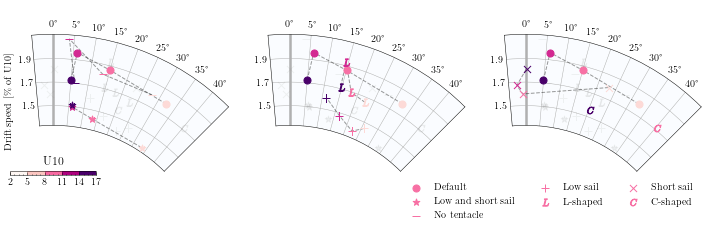

In [20]:
import matplotlib as mpl
cmap = plt.get_cmap('RdPu')
# List of different model identifiers
modelss = [
    '11111',          # Default model
    '11211',          # Model with low sail
    '12111',          # Model with short sail
    '12211',          # Model with low and short sail
    'C1111',          # C-shaped model
    'L1111',          # L-shaped model
    '11111_notent'    # Model without tentacle
]

# Human-readable names corresponding to model identifiers
names = [
    'Default',               # Default model name
    'Low sail',              # Model with a low sail name
    'Short sail',            # Model with a short sail name
    'Low and short sail',    # Model with low and short sail name
    'C-shaped',              # C-shaped model name
    'L-shaped',              # L-shaped model name
    'No tentacle'            # Model without a tentacle name
]

# List of markers used for plotting models
markers = [
    'o',    # Circle marker
    '+',    # Plus marker
    'x',    # X marker
    '*',    # Asterisk marker
    '$C$',  # C-shaped marker (using LaTeX style)
    '$L$',  # L-shaped marker (using LaTeX style)
    '_'     # Underscore marker
]

col_bools = [
    [True, False, False, True, False, False, True],
    [True, True, False, False, False, True, False],
    [True, False, True, False, True, False, False]
]

# Create a polar subplot with three columns
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 5),
                      ncols=3, nrows=1, sharex=True, sharey=True)
def_leg = True

# Iterate through subplots
for isp in range(len(col_bools)):
    col_bool = col_bools[isp]
    wind_speeds = [2, 6, 8, 12]
    U10_chosed = [U10[1], U10[3], U10[-3], U10[7]]
    
    import warnings 
    warnings.filterwarnings("ignore")
    mpl.style.use(['science', 'high-contrast'])

    # Configure subplot settings
    ax[isp].set_thetamin(-5)
    ax[isp].set_thetamax(45)
    ax[isp].set_theta_zero_location("N")
    ax[isp].set_theta_direction('clockwise')
    ax[isp].set_rmax(3.5)
    ax[isp].set_rorigin(0)
    ax[isp].set_rticks([1.5, 1.7, 1.9])
    ax[isp].set_xticks(np.pi/180*np.array([0, 5, 10, 15, 20, 25, 30, 35, 40]))
    ax[isp].xaxis.grid(zorder=0)
    legends = [False] * len(modelss)
    ax[isp].set_facecolor('w')
    ind = 0
    gridlines = ax[isp].xaxis.get_gridlines()
    gridlines[ind].set_linewidth(2.5)

    a = np.full((len(wind_speeds), len(modelss)), np.nan)
    b = np.full((len(wind_speeds), len(modelss)), np.nan)

    # Iterate through wind speeds
    for ws, i, u in zip(wind_speeds, range(len(wind_speeds)), U10_chosed):
        for model, name, mark, leg, j, co in zip(modelss, names, markers, legends, range(len(modelss)), col_bool):
            angle_r1 = []
            speed_r1 = []

            for hand, nu in zip(['L', 'R'], [1, -1]):
                if os.path.exists(path_results+'WS'+str(ws)+'Model'+hand+model+'_Calib.mat'):
                    _, _, xr, yr = open_model(ws, hand+model, path=path_results)

                    for run in range(len(xr)):
                        fps = get_fps(ws, hand+model, run)
                        angle_r, speed_r, _, _ = get_angle(xr[run], yr[run], fps,
                                                       path_fig=path_fig,
                                                       name=str(ws)+hand+model+str(run), plot=False)
                        angle_r1.append(nu * angle_r)
                        speed_r1.append(speed_r)

            angle1 = np.nanmean(angle_r1)
            speed1 = np.nanmean(speed_r1/u)

            a[i][j] = np.deg2rad(angle1)
            b[i][j] = speed1 * 100

            cmaplines = 'RdPu'
            cmaprdpu = plt.get_cmap(cmaplines)
            if co:
                c = cmaprdpu(u / np.nanmax(U10))
                al = 1
            else:
                c = 'grey'
                al = 0.1

            if not np.isnan(angle1):
                if not leg and ws == 6 and c == cmaprdpu(u / np.nanmax(U10)):
                    if model != '11111':
                        ax[isp].scatter(np.deg2rad(angle1), speed1 * 100, facecolor=c,
                                       alpha=al, marker=mark, zorder=5, s=50, label=name)
                        leg = True
                    elif def_leg:
                        ax[isp].scatter(np.deg2rad(angle1), speed1 * 100, facecolor=c,
                                       alpha=al, marker=mark, zorder=5, s=50, label=name)
                        def_leg = False
                    else:
                        ax[isp].scatter(np.deg2rad(angle1), speed1 * 100, facecolor=c,
                                       alpha=al, marker=mark, zorder=5, s=50)
                else:
                    ax[isp].scatter(np.deg2rad(angle1), speed1 * 100, facecolor=c,
                                   alpha=al, marker=mark, zorder=5, s=50)
    
    
    
    
    for j in range(len(modelss)):
        if col_bool[j]:
            al = 0.4
        else:
            al = 0
        ax[isp].plot(a[:, j], b[:, j], c='k', linewidth=1, linestyle='--', alpha=al)
    ax[isp].set_rticks([1.5, 1.7, 1.9])

    ax[isp].patch.set_color('aliceblue')
    ax[isp].patch.set_alpha(.3)
    ax[0].set_ylabel('Drift speed [$\%$ of U10]')
    if isp == 2:
        fig.legend(ncol=3, bbox_to_anchor=(0.5, 0., 0.4, 0.3))

    bounds=[2,5,8,11,14,17]
    norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
    sm = plt.cm.ScalarMappable(cmap=cmaplines, norm=norm)
    
cax = fig.add_axes([0.1, 0.3, 0.1, 0.01])
cb=fig.colorbar(sm,cax=cax,orientation='horizontal',pad=-2)
cb.ax.set_title('U10')

fig.savefig(path_fig2+'PolarAllSubplotsMean_test.png',facecolor='w',dpi=500)
plt.show()


In [21]:
U10

array([ 1.27681702,  2.57378534,  5.35451352,  8.12434879,  9.51956871,
       10.92273793, 13.86621703, 16.84019246])

# Table with speed 

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def open_model_manual(wind,model,nruns=5,path=path_results):
    
    x = []
    y = []
    
    x_norm = [] # x,y normalized by first values for prettier plots
    y_norm = [] 
    

    fn_traj = path+'WS'+str(wind)+'Model'+str(model)+'_Calib.mat'
    f_traj = scio.loadmat(fn_traj)
    xc = f_traj['x_calib'][0]
    yc = f_traj['y_calib'][0]
    
    len_per_run = []
    for i in range(len(xc)):
        
        x_run = xc[i]
        y_run = yc[i]
        
        if len(x_run) != 0:

            len_per_run.append(len(x_run[0]))
        
            condi = np.logical_and(~np.isnan(x_run),~np.isnan(y_run))
            x_run = x_run[condi]
            y_run = y_run[condi]

            x_run = - x_run

            x_run_norm = x_run - x_run[0]
            y_run_norm = y_run - y_run[0]


            x.append(x_run)
            y.append(y_run)

            x_norm.append(x_run_norm)
            y_norm.append(y_run_norm)

    return x,y, x_norm, y_norm, np.array(len_per_run)

def get_angle_manual(x,y,fps,len_x,path_fig=path_fig,name='o',plot=True):
    
    if len(x)==0:

        angle = np.nan
        speed = np.nan
        pente = np.nan

    else:
        if plot:
            fig,ax=plt.subplots()
            ax.scatter(x,y)
            ax.set_xlim(-100,100)
            ax.set_ylim(0,500)
        
        x_reshaped = x[~np.isnan(x)]
        y_reshaped = y[~np.isnan(y)]

        x_reshaped = x_reshaped.reshape(-1,1)
        y_reshaped = y_reshaped.reshape(-1,1)

        reg = LinearRegression().fit(x_reshaped,y_reshaped)
        r2 = reg.score(x_reshaped,y_reshaped)

        pente = reg.coef_[0][0]

        dx = x[-1] - x[0]
        dy = y[-1] - y[0]
        
        if r2 > 0.8:
            dy = dx*pente
            if plot:
                ax.plot(x,pente*x+reg.intercept_,c='r',linewidth=2)
        else:
            if plot:
                ax.plot([x[0],x[-1]],[y[0],y[-1]],c='k',linewidth=2)
        angle = np.arctan(dx/dy)*180/np.pi
        
        dist = np.sqrt((dx/100)**2 + (dy/100)**2)
        dt = len_x/fps
        speed = dist/dt
        
        #if r2 < 0.5:
        #    angle = np.nan
        #    speed = np.nan
        #    pente = np.nan
        if plot:  
            fig.savefig(path_fig+'verif_pente/'+name+'.png',facecolor='w')
            plt.close()
    return angle,speed, pente,r2

Default  0.017412587656033558
Small  0.015014451529374211
Formol  0.027193818146818174  +/-  0.005745895236755526
Model float  0.024720085668961778  +/-  0.006534861956533376


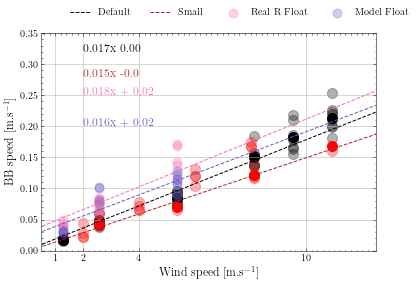

In [146]:
path= '/home/nbourg/Bureau/clean_plots_treatment_bb/process_scripts/Results_Traj_Detection/Calib/'
n_runs = 5

plt.style.use(['science','high-vis'])
size=80
al=.3
col='hotpink'
col2='slateblue'

leg = leg2 = 0
x,y = [],[]
#axs.set_ylim(0,0.6)


fig,ax =plt.subplots(figsize=(6,4))
ax.yaxis.grid()
ax.set_ylim(0,.35)
ax.set_xlim(0.5,12.5)

ms=100

x = []
y = []

rws = []
for ws,u in zip([1,2,4,6,7,8,10,12],U10):
    model = 'R11111'
    model2 = 'L11111'
    
    _,_,xr,yr = open_model(ws,model,path=path)
    _,_,xl,yl = open_model(ws,model2,path=path)
    
    s_run = []
    for run in range(len(xr)):
        
        fps = get_fps(ws,model,run)
        angle_r, speed_r,_,_ = get_angle(xr[run],yr[run],fps)
        ax.scatter(u,speed_r,color='k',s=ms,alpha=.3)
        x.append(u)
        y.append(speed_r)
        
        s_run.append(speed_r)
        
        rws.append(speed_r/u)
    for run in range(len(xl)):
        
        fps = get_fps(ws,model2,run)

        angle_l, speed_l,_,_ = get_angle(xl[run],yl[run],fps)
        ax.scatter(u,speed_l,color='k',s=ms,alpha=.3)
        x.append(u)
        y.append(speed_l)
        s_run.append(speed_l)
        rws.append(speed_l/u)

    ax.scatter(u,np.nanmean(s_run),c='k',s=ms)

print("Default ",np.nanmean(rws))    
x = np.array(x)
y = np.array(y)

y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 100, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", linestyle='--',label='Default');
ax.text(2,0.32, str(b)[0:5]+'x'+' '+str(a)[0:4],fontsize=12,fontweight='bold')

###---------------------------

path= '/home/nbourg/Bureau/clean_plots_treatment_bb/process_scripts/Results_Traj_Detection/Calib/'
n_runs = 5

x = []
y = []
rws = []
for ws,u in zip([2,4,6,8],[U10[1],U10[2],U10[3],U10[5]]):
    model = 'R21111'
    model2 = 'L21111'
    
    _,_,xr,yr = open_model(ws,model,path=path)
    _,_,xl,yl = open_model(ws,model2,path=path)
    
    s_run=[]
    for run in range(len(xr)):
        
        fps = get_fps(ws,model,run)
        angle_r, speed_r,_,_ = get_angle(xr[run],yr[run],fps)
        ax.scatter(ws,speed_r,color='r',alpha=.3,s=ms)
        
        s_run.append(speed_r)
        rws.append(speed_r/u)

        x.append(u)
        y.append(speed_r)
    
    for run in range(len(xl)):
        
        fps = get_fps(ws,model2,run)

        angle_l, speed_l,_,_ = get_angle(xl[run],yl[run],fps)
        ax.scatter(u,speed_l,color='r',alpha=.3,s=ms)
        rws.append(speed_l/u)
        
        s_run.append(speed_l)
        
        x.append(u)
        y.append(speed_l)
    
    ax.scatter(u,np.nanmean(s_run),color='r',s=ms)
print('Small ', np.nanmean(rws))
x = np.array(x)
y = np.array(y)

y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 100, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="firebrick", linestyle='--',label='Small');
ax.text(2,0.28, str(b)[0:5]+'x'+' '+str(a)[0:4],fontsize=12,fontweight='bold',color='firebrick')


#---- plot tricks
ax.set_ylabel('BB speed [m.s$^{-1}$]',fontsize=12)
ax.set_xlabel('Wind speed [m.s$^{-1}$]',fontsize=12)
ax.grid(zorder=0)







############

size=80
al=.3
col='hotpink'
col2='slateblue'
col3 = 'dodgerblue'

leg = leg2 =leg3 = 0
x,y = [],[]

xm,ym = [], []
rws_formol, rws = [], []
#axs.set_ylim(0,0.6)
for ws,fps,u in zip([1,2,4,10],[2,1,1,1],[U10[0],U10[1],U10[2],U10[6]]):
    
    _,_,xr,yr,len_r = open_model_manual(ws,'real_bb_Formol1BigR',path=path)
    
    
    for run in range(len(xr)):
        fps = get_fps(ws,"real_bb_Formol1BigR",run+1)
        angle_r, speed_r,_,_ = get_angle_manual(xr[run],yr[run],
                                         fps, len_r[run],
                                         path_fig=path_fig,
                                         name=str(ws)+"real_bb_Formol1BigR"+str(run))        
        if leg2==0:
            ax.scatter(u,speed_r,alpha=al,color=col,s=size,label='Real R Float')
            leg2 = 1

        else:
            ax.scatter(u,speed_r,alpha=al,color=col,s=size)

        x.append(u)
        y.append(speed_r)
        rws_formol.append(speed_r/u)

    if ws < 6:
        _,_,xr2,yr2,len_r2 = open_model_manual(ws,'R11111_nobulge',path=path)

        

        for run in range(len(xr2)):
            fps = get_fps(ws,"R11111_nobulge",run+1)

            angle_r2, speed_r2,_,_ = get_angle_manual(xr2[run],yr2[run],
                                             fps, len_r2[run],
                                             path_fig=path_fig,
                                             name=str(ws)+"R11111_nobulge"+str(run))
            if leg==0:
                ax.scatter(u,speed_r2,alpha=al,color=col2,s=size,label='Model Float')
                leg=1
            else:
                
                ax.scatter(u,speed_r2,alpha=al,color=col2,s=size)

            xm.append(u)
            ym.append(speed_r2)
            rws.append(speed_r2/u)

        if ws>1:
            
            _,_,xr3,yr3,len_r3 = open_model_manual(ws,'L11111_nobulge',path=path)


            for run in range(len(xr2)):
                fps = get_fps(ws,"L11111_nobulge",run+1)

                angle_r3, speed_r3,_,_ = get_angle_manual(xr3[run],yr3[run],
                                                 fps, len_r3[run],
                                                 path_fig=path_fig,
                                                 name=str(ws)+"R11111_nobulge"+str(run))

                ax.scatter(u,speed_r3,alpha=al,color=col2,s=size)

                xm.append(u)
                ym.append(speed_r3)

                rws.append(speed_r3/u)

                
                    
print("Formol ",np.nanmean(100*rws_formol),' +/- ',np.nanstd(100*rws_formol) )
print('Model float ', np.nanmean(100*rws),' +/- ',np.nanstd(100*rws))
x = np.array(x)
y = np.array(y)

y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 100, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="hotpink", linestyle='--');
ax.text(2,0.25, str(b)[0:5]+'x'+' + '+str(a)[0:4],fontsize=12,fontweight='bold',color='hotpink')

#------------
                    
x = np.array(xm)
y = np.array(ym)

y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 100, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color=col2, linestyle='--');
ax.text(2,0.2, str(b)[0:5]+'x'+' + '+str(a)[0:4],fontsize=12,fontweight='bold',color=col2)


ax.set_xlim(0.5,12.5)

ax.set_xticks([1,2,4,10],fontsize=12)
ax.grid(zorder=0)

fig.legend(ncol=5)





fig.savefig(path_fig+'BB_speed_ALL_U10.png',facecolor='w',dpi=500)